In [105]:
import re
import unicodedata
import pandas as pd

from bs4 import BeautifulSoup
import nltk

import acquire as ac
import prepare as pr 
import requests

import env

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud



In [6]:
def get_db_url(database, host=env.host, user=env.username, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


# 1 Spam Data

### Load the spam data set

In [8]:
url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")

In [9]:
df

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."


In [ ]:
### clean

In [11]:
# list of words i want to remove
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    
    'A simple function to cleanup text data'
    
    #create lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #create list of stopwords for english and add our words
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # normalize text
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    # if not word or space remove
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [17]:
# creates a dataframe where index is ham and spam, creates a percentage, then dataframes i
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
# create column names
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


# 3 pieces
## legit text, spam text, all text

In [ ]:
# legit

In [24]:
# creates a mask, the convert to text string
# then adds them all together
# Then Runs function on them
ham_words = clean(''.join(df[df.label == 'ham'].text))

In [ ]:
# spam

In [70]:
spam_words = clean(' '.join(df[df.label == 'spam'].text))


In [76]:
clean(' '.join(df[df.label == 'spam'].text))

['free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'freemsg',
 'hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 'a150',
 'rcv',
 'winner',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'a900',
 'prize',
 'reward',
 'claim',
 'call',
 '09061701461',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobile',
 '11',
 'month',
 'entitled',
 'update',
 'latest',
 'colour',
 'mobile',
 'camera',
 'free',
 'call',
 'mobile',
 'update',
 'co',
 'free',
 '08002986030',
 'six',
 'chance',
 'win',
 'cash',
 '100',
 '20000',
 'pound',
 'txt',
 'csh11',
 'send',
 '87575',
 'cost',
 '150pday',
 '6days',
 '16',
 'tsandcs',
 'apply',
 'reply',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'a100000'

In [ ]:
# all words

In [26]:
all_words = clean(' '.join(df.text))


# Create a Series

In [28]:
# take the list of words we created, converte to series, and value count it
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [34]:
ham_freq.head(20)

im       342
get      303
go       266
ur       240
dont     230
know     226
like     221
come     218
got      218
call     217
ill      213
time     190
want     174
good     173
love     173
need     169
day      167
4        164
going    155
one      154
dtype: int64

In [35]:
spam_freq.head(20)

call       359
free       216
txt        150
ur         144
text       137
mobile     135
4          119
claim      115
stop       113
reply      102
prize       94
get         83
tone        73
service     72
new         69
send        67
nokia       65
urgent      63
week        62
cash        62
dtype: int64

In [46]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))


#### What are the most freq occuring words

In [49]:
word_counts.sort_values(by = 'all',ascending= False).head(15)

,all,ham,spam
call,600,217,359
im,462,342,13
get,397,303,83
ur,384,240,144
go,304,266,31
4,287,164,119
dont,279,230,22
ok,277,107,5
free,275,47,216
know,267,226,26


#### what words uniquely identift as spam or ham

In [50]:
word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6)

,all,ham,spam
said,86,85,0
ask,88,86,0
da,132,104,0
i_,117,107,0
say,118,107,0
lor,160,109,0


In [52]:
word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)

,all,ham,spam
18,43,0,43
tc,52,0,50
guaranteed,50,0,50
tone,73,0,73
prize,94,0,94
claim,115,0,115


In [54]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,342,13,0.038011
like,245,221,13,0.058821
need,182,169,11,0.065085
good,235,173,12,0.069360
dont,279,230,22,0.095648
contact,70,14,56,3.997145
free,275,47,216,4.594767
win,76,13,61,4.688701
mobile,150,14,135,9.635974
txt,163,12,150,12.489592


### Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1
...,...,...,...
zoe,2,0,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1


In [91]:
ham_s = (' '.join(ham_words))

In [92]:
bigrams = nltk.ngrams(ham_s.split(), 2)
list(bigrams)

[('go', 'jurong'),
 ('jurong', 'point'),
 ('point', 'crazy'),
 ('crazy', 'available'),
 ('available', 'bugis'),
 ('bugis', 'n'),
 ('n', 'great'),
 ('great', 'world'),
 ('world', 'la'),
 ('la', 'e'),
 ('e', 'buffet'),
 ('buffet', 'cine'),
 ('cine', 'got'),
 ('got', 'amore'),
 ('amore', 'watok'),
 ('watok', 'lar'),
 ('lar', 'joking'),
 ('joking', 'wif'),
 ('wif', 'oniu'),
 ('oniu', 'dun'),
 ('dun', 'say'),
 ('say', 'early'),
 ('early', 'hor'),
 ('hor', 'c'),
 ('c', 'already'),
 ('already', 'saynah'),
 ('saynah', 'dont'),
 ('dont', 'think'),
 ('think', 'go'),
 ('go', 'usf'),
 ('usf', 'life'),
 ('life', 'around'),
 ('around', 'thougheven'),
 ('thougheven', 'brother'),
 ('brother', 'like'),
 ('like', 'speak'),
 ('speak', 'treat'),
 ('treat', 'like'),
 ('like', 'aid'),
 ('aid', 'patentas'),
 ('patentas', 'per'),
 ('per', 'request'),
 ('request', 'melle'),
 ('melle', 'melle'),
 ('melle', 'oru'),
 ('oru', 'minnaminunginte'),
 ('minnaminunginte', 'nurungu'),
 ('nurungu', 'vettam'),
 ('vettam', 

In [90]:
spam_s= (' '.join(spam_words))

In [86]:
bigrams = nltk.ngrams(spam_s.split(), 2)
list(bigrams)

[('free', 'entry'),
 ('entry', 'wkly'),
 ('wkly', 'comp'),
 ('comp', 'win'),
 ('win', 'fa'),
 ('fa', 'cup'),
 ('cup', 'final'),
 ('final', 'tkts'),
 ('tkts', '21st'),
 ('21st', 'may'),
 ('may', '2005'),
 ('2005', 'text'),
 ('text', 'fa'),
 ('fa', '87121'),
 ('87121', 'receive'),
 ('receive', 'entry'),
 ('entry', 'questionstd'),
 ('questionstd', 'txt'),
 ('txt', 'ratetcs'),
 ('ratetcs', 'apply'),
 ('apply', '08452810075over18s'),
 ('08452810075over18s', 'freemsg'),
 ('freemsg', 'hey'),
 ('hey', 'darling'),
 ('darling', '3'),
 ('3', 'week'),
 ('week', 'word'),
 ('word', 'back'),
 ('back', 'id'),
 ('id', 'like'),
 ('like', 'fun'),
 ('fun', 'still'),
 ('still', 'tb'),
 ('tb', 'ok'),
 ('ok', 'xxx'),
 ('xxx', 'std'),
 ('std', 'chgs'),
 ('chgs', 'send'),
 ('send', 'a150'),
 ('a150', 'rcv'),
 ('rcv', 'winner'),
 ('winner', 'valued'),
 ('valued', 'network'),
 ('network', 'customer'),
 ('customer', 'selected'),
 ('selected', 'receivea'),
 ('receivea', 'a900'),
 ('a900', 'prize'),
 ('prize', 'rew

In [97]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

In [87]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(ill, call)     47
(let, know)     34
(dont, know)    29
(new, year)     28
(im, going)     21
dtype: int64

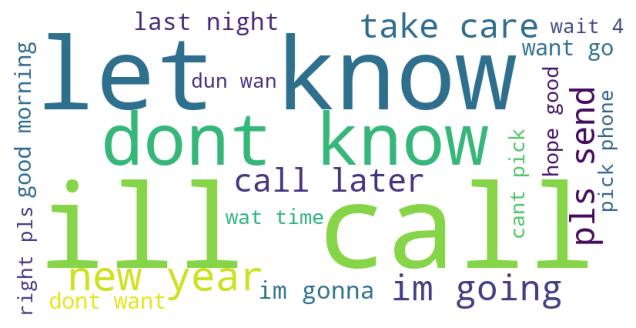

In [88]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

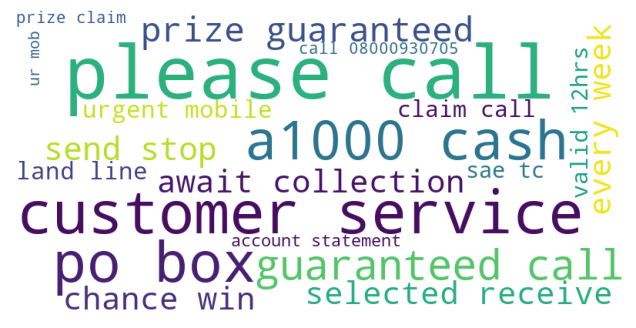

In [98]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

# 2. Explore the blog articles using the techniques discuessed in the exploration lesson


In [113]:
df =pd.DataFrame(ac.get_blog_articles(url))

In [106]:
url = 'https://codeup.com/blog/'
headers = {'User-Agent': 'Codeup Data Science'} # Some websites don't accept the pyhon-requests default user-agent
# headers, change python request
response = requests.get(url, headers=headers) 

In [107]:
# Make a soup variable holding the response content
soup = BeautifulSoup(response.content, 'html.parser')

In [108]:
# anchors, looking for more-link
links = soup.find_all('a','more-link')

In [109]:
# creating empty list
url = []

In [110]:
# list of links
for i in range(0,len(links)):
    url_temp = (links[i]['href'])
    
    url.append(url_temp)

In [114]:
df

,title,content
0,Black Excellence in Tech: Panelist Spotlight -...,"[\n, Black excellence in tech: Panelist Spotli..."
1,Black excellence in tech: Panelist Spotlight -...,"[\n, Black excellence in tech: Panelist Spotli..."
2,Black excellence in tech: Panelist Spotlight -...,"[\n, Black excellence in tech: Panelist Spotli..."
3,Black excellence in tech: Panelist Spotlight -...,"[\n, Black excellence in tech: Panelist Spotli..."
4,Coding Bootcamp or Self-Learning? Which is Bes...,"[\n, If you’re interested in embarking on a ca..."
5,Codeup Among Top 58 Best Coding Bootcamps of 2...,"[\n, Codeup is pleased to announce we have bee..."


# clean

# Token

In [119]:
for i in range(0,len(df)):
    content = df.content[i]
    content_to_add = pr.basic_clean(''.join(content))
    df.loc[i, 'clean'] = content_to_add 


In [124]:
for i in range(0,len(df)):
    content = df.clean[i]
    content_to_add = pr.tokenize(df.clean[i])
    df.loc[i, 'clean'] = content_to_add 


# stemmer

In [126]:
for i in range(0,len(df)):
    content = df.clean[i]
    content_to_add = pr.stem(content)
    df.loc[i, 'stemmed'] = content_to_add 


In [155]:
first_blog_words = pd.Series(df.stemmed[0].split())

In [139]:
first_blog = pd.Series(df.stemmed[0].split()).value_counts() 

In [140]:
sec_blog  = pd.Series(df.stemmed[1].split()).value_counts() 

In [172]:
sec_blog_words  = pd.Series(df.stemmed[1].split())

In [141]:
thi_blog  = pd.Series(df.stemmed[2].split()).value_counts() 

In [173]:
thi_blog_words = pd.Series(df.stemmed[2].split())

In [154]:
fou_blog = pd.Series(df.stemmed[3].split()).value_counts() 

In [174]:
fou_blog_words = pd.Series(df.stemmed[3].split())

In [143]:
fif_blog = pd.Series(df.stemmed[4].split()).value_counts() 

In [175]:
fif_blog_words = pd.Series(df.stemmed[4].split())

In [149]:
blog_wcount = pd.concat([first_blog,sec_blog,thi_blog,fou_blog,fif_blog],axis = 1,sort = True).set_axis(['first','second','third','fourth','fifth'],axis = 1, inplace = False).fillna(0).apply(lambda s: s.astype(int))

In [ ]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
        

# bigrams

In [158]:
top_20_fb_bigrams = (pd.Series(nltk.ngrams(first_blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_fb_bigrams.head()

(black, excel)    2
(in, tech)        2
(on, februari)    2
(is, a)           2
(wilmari, de)     2
dtype: int64

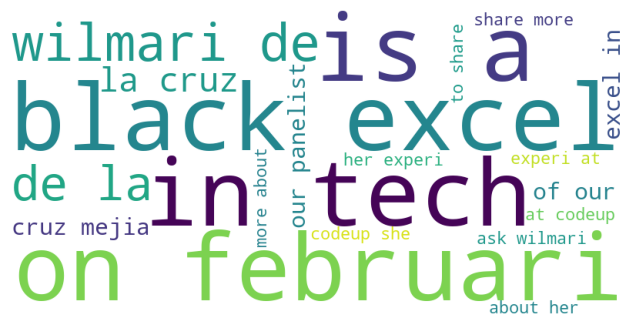

In [159]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_fb_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [178]:
top_20_sb_bigrams = (pd.Series(nltk.ngrams(sec_blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_sb_bigrams.head() 

(the, program)     3
(black, excel)     2
(in, the)          2
(our, panelist)    2
(to, the)          2
dtype: int64

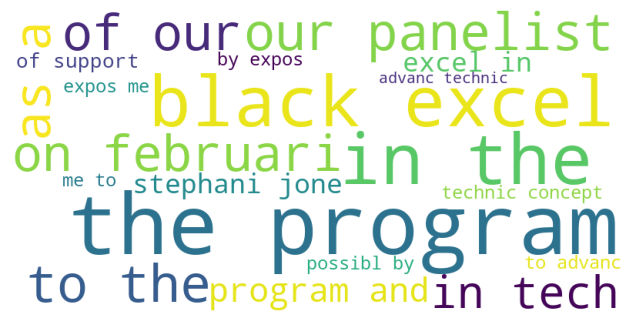

In [183]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_sb_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show() 

In [179]:
top_20_tb_bigrams = (pd.Series(nltk.ngrams(thi_blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_tb_bigrams.head() 

(black, excel)    3
(in, tech)        3
(at, codeup)      3
(excel, in)       3
(tech, panel)     2
dtype: int64

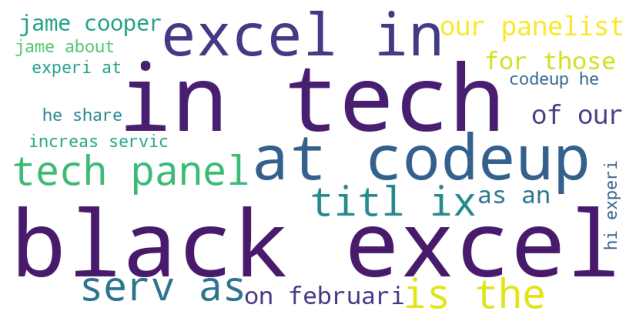

In [184]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_tb_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [180]:
top_20_fou_bigrams = (pd.Series(nltk.ngrams(fou_blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_fou_bigrams.head() 

(opportun, for)      3
(provid, support)    3
(black, excel)       2
(codeup, ha)         2
(codeup, she)        2
dtype: int64

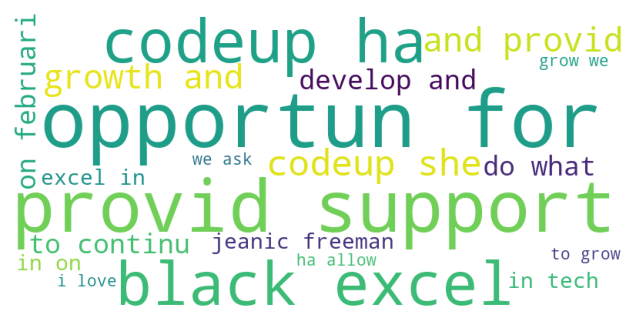

In [185]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_fou_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [182]:
top_20_fib_bigrams = (pd.Series(nltk.ngrams(fif_blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_fib_bigrams.head() 

(code, bootcamp)    8
(to, you)           3
(if, you)           3
(in, tech)          3
(career, in)        3
dtype: int64

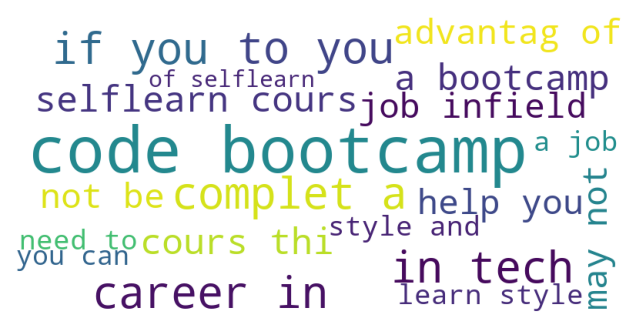

In [186]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_fib_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off') 
plt.show()

# 3.Explore the news article using the techniques discussed in the exploration lesson. use the category var when exploring

In [189]:
df = pd.DataFrame(ac.get_new_article_sports())

In [191]:
df.content

0    \nNearly 76% see the world returning to normal...
Name: content, dtype: object

In [192]:
for i in range(0,len(df)):
    content = df.content[i]
    content_to_add = pr.basic_clean(''.join(content))
    df.loc[i, 'clean'] = content_to_add 


In [194]:
for i in range(0,len(df)):
    content = df.clean[i]
    content_to_add = pr.tokenize(df.clean[i])
    df.loc[i, 'clean'] = content_to_add 

In [195]:
# stem

,title,content,category,clean
0,68% confident India will improve performance a...,\nNearly 76% see the world returning to normal...,sports,nearly 76 see the world returning to normalcy ...


In [196]:
for i in range(0,len(df)):
    content = df.clean[i]
    content_to_add = pr.stem(content)
    df.loc[i, 'stemmed'] = content_to_add

In [ ]:
clean(' '.join(df[df.label == 'spam'].text))

In [235]:
stri = df['stemmed'].astype('string')

In [248]:
df.stemmed = df.stemmed.astype('string')

In [251]:
blog_word = df.stemmed[0].split()

In [252]:
blog_word

['nearli',
 '76',
 'see',
 'the',
 'world',
 'return',
 'to',
 'normalci',
 'with',
 'the',
 'tokyo',
 'olymp',
 '53',
 'of',
 'the',
 'respond',
 'are',
 'veri',
 'excited2274',
 'and',
 '2198',
 'are',
 'keen',
 'to',
 'watch',
 'archeri',
 'and',
 'wrestl',
 'respect',
 'follow',
 'by',
 'badminton',
 '1355',
 'and',
 'box',
 '8',
 '3371',
 'said',
 'theyll',
 'watch',
 'some',
 'other',
 'sportmajor',
 '74',
 'believ',
 'the',
 'game',
 'help',
 'bring',
 'the',
 'countri',
 'togeth',
 'and',
 'around',
 '66',
 'see',
 'it',
 'as',
 'an',
 'opportun',
 'for',
 'global',
 'bonding72',
 'feel',
 'the',
 'game',
 'have',
 'a',
 'posit',
 'impact',
 'on',
 'societi',
 'inspir',
 'younger',
 'gener',
 'to',
 'particip',
 'in',
 'sportsaround',
 '70',
 'are',
 'of',
 'the',
 'view',
 'that',
 'there',
 'arent',
 'enough',
 'polici',
 'in',
 'india',
 'to',
 'promot',
 'sport',
 'and',
 'fit',
 'after',
 'a',
 'yearlong',
 'delay',
 'the',
 'tokyo',
 '2020',
 'olymp',
 'is',
 'all',
 'set

In [263]:
top_20_blog_bigrams = (pd.Series(nltk.ngrams(blog_word, 1))
                      .value_counts()
                      .head(20))

top_20_blog_bigrams.head()

(the,)    34
(to,)     21
(of,)     17
(and,)    17
(are,)    10
dtype: int64

# tri

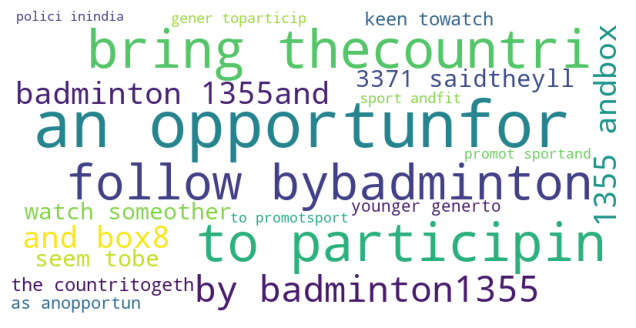

In [262]:
data = {k[0] + ' ' + k[1] + k[2]: v for k, v in top_20_blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

# unigram

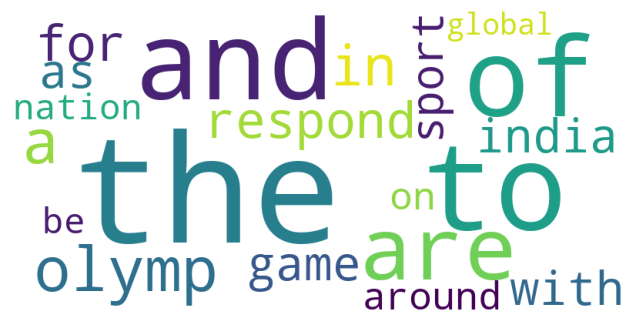

In [264]:
data = {k[0]: v for k, v in top_20_blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()